In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import GloVe
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

## 1. Description

### About
In times of emergencies, Twitter has become an essential platform for real-time communication. The widespread use of smartphones allows individuals to report emergencies as they occur. As a result, various organizations, such as disaster relief agencies and news outlets, are increasingly interested in automatically monitoring Twitter. However, it can be challenging to determine whether a tweet genuinely reports a disaster or if it is using language figuratively.

### Objective
The primary objective is to train a model that can accurately differentiate between genuine disaster-related tweets and others that may be misleading or metaphorical. This process will begin with an exploration of text mining techniques and gradually introduce more complex concepts, ranging from N-grams to word embeddings and transformers.

In [5]:
# Load the training and testing dataset
training_data = pd.read_csv('./data/train.csv')
testing_data = pd.read_csv('./data/test.csv')

# Display the first five rows of the training dataset to preview its structure and content
training_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Display the datasets
print(f"Number of entries in the training dataset: {training_data.shape[0]}")
print(f"Number of entries in the test dataset: {testing_data.shape[0]}")
print(f"Distribution of target labels:\n{training_data['target'].value_counts()}")

Number of entries in the training dataset: 7613
Number of entries in the test dataset: 3263
Distribution of target labels:
target
0    4342
1    3271
Name: count, dtype: int64


## 2. EDA

/var/folders/ts/mcsz_mqn33s7mpvcvwd8l57w0000gn/T/ipykernel_44541/1934291182.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=training_data, palette='Blues')


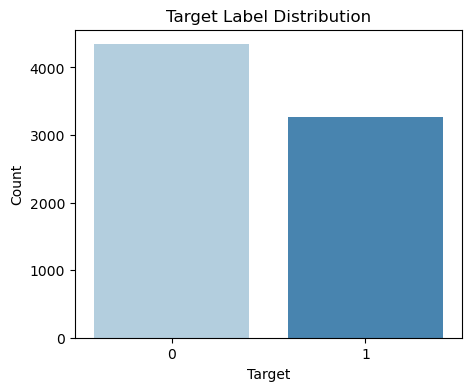

In [15]:
# Plot the target variable distribution in the training dataset with a different color palette
plt.figure(figsize=(5, 4))
sns.countplot(x='target', data=training_data, palette='Blues')
plt.title('Target Label Distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

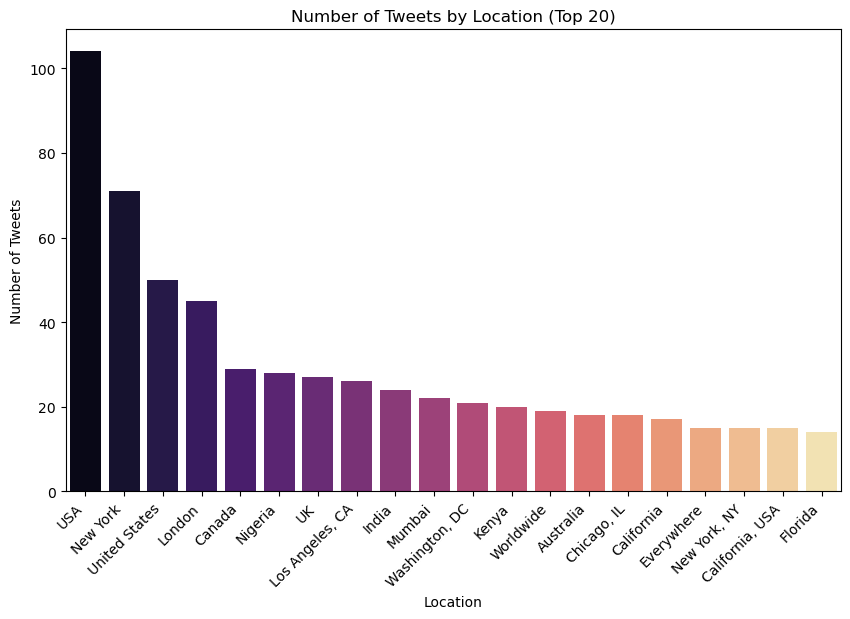

In [22]:
# Visualize the number of tweets by location (Top 20) with vertical bars and a different color palette
plt.figure(figsize=(10, 6))
top_locations = training_data['location'].value_counts().head(20)
sns.barplot(x=top_locations.index, y=top_locations.values, hue=top_locations.index, palette='magma', dodge=False)
plt.title('Number of Tweets by Location (Top 20)')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability
plt.xlabel('Location')
plt.ylabel('Number of Tweets')
plt.legend([], [], frameon=False)  # Hide the legend
plt.show()

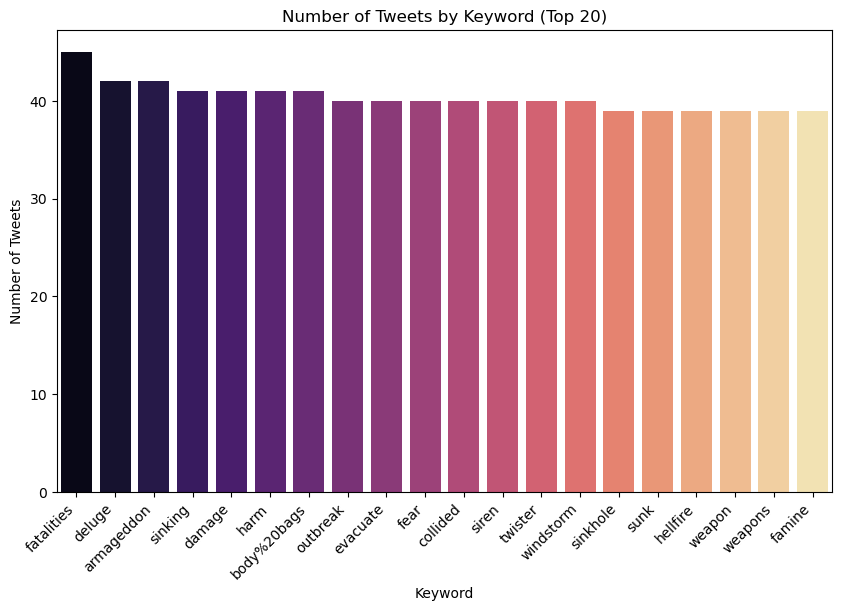

In [25]:
# Visualize the number of tweets by keyword (Top 20) with vertical bars and the magma color palette
plt.figure(figsize=(10, 6))
top_keywords = training_data['keyword'].value_counts().head(20)
sns.barplot(x=top_keywords.index, y=top_keywords.values, hue=top_keywords.index, palette='magma', dodge=False)
plt.title('Number of Tweets by Keyword (Top 20)')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability
plt.xlabel('Keyword')
plt.ylabel('Number of Tweets')
plt.legend([], [], frameon=False)  # Hide the legend
plt.show()

Compare the distributions of text lengths between the train and test datasets.

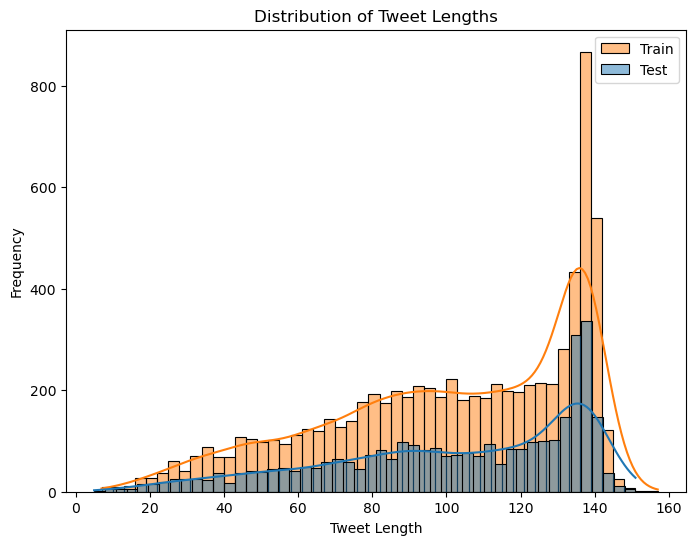

In [33]:
# Plot the distribution of tweet lengths for training and test datasets with a different color scheme
plt.figure(figsize=(8, 6))
sns.histplot(training_data['text'].apply(len), bins=50, kde=True, color='#FF7F0E', label='Train')  # Orange
sns.histplot(testing_data['text'].apply(len), bins=50, kde=True, color='#1F77B4', label='Test')   # Blue
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Missing
The location variable has a significant percentage of missing values.

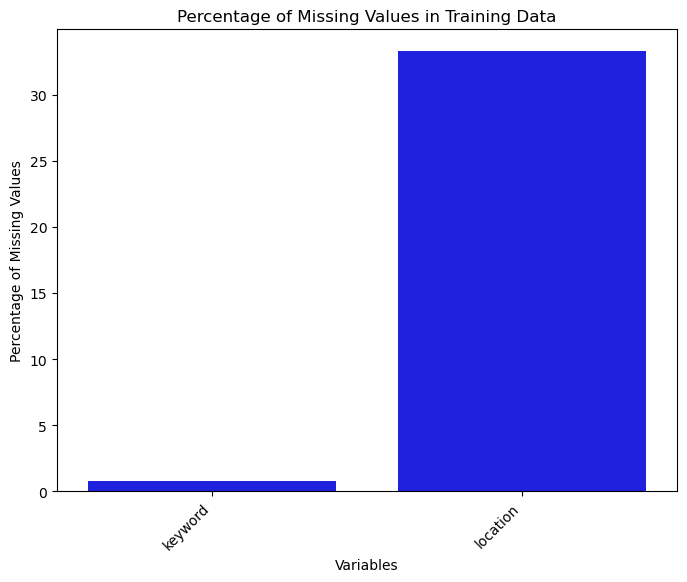

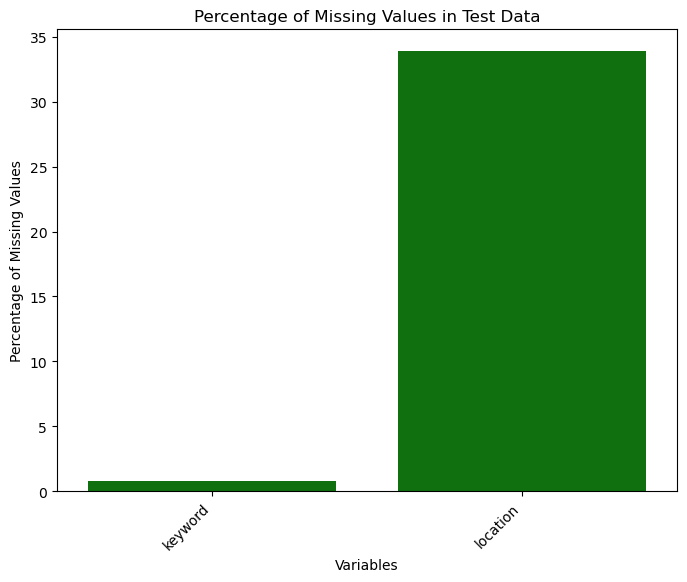

In [35]:
# Calculate the percentage of missing values for each column in training and test datasets
missing_train = (training_data.isnull().sum() / training_data.shape[0]) * 100
missing_test = (testing_data.isnull().sum() / testing_data.shape[0]) * 100

# Filter out columns with no missing values
missing_train = missing_train[missing_train > 0]
missing_test = missing_test[missing_test > 0]

# Plot the percentage of missing values for the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(x=missing_train.index, y=missing_train.values, color='blue')
plt.title('Percentage of Missing Values in Training Data')
plt.xlabel('Variables')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.show()

# Plot the percentage of missing values for the test dataset
plt.figure(figsize=(8, 6))
sns.barplot(x=missing_test.index, y=missing_test.values, color='green')
plt.title('Percentage of Missing Values in Test Data')
plt.xlabel('Variables')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.show()

### Text Processing

• Preprocessing text is an essential step in preparing raw text data for analysis. This involves several key tasks, including converting text to lowercase, removing URLs, mentions, hashtags, punctuation, and tokenizing the text into individual words.


• After preprocessing, it is useful to visualize word frequencies and analyze bigrams (pairs of consecutive words) and trigrams (triplets of consecutive words). These visualizations can help identify common terms and phrases that may be important for distinguishing disaster-related tweets from those that are not.

In [38]:
import re
import string
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# Download stopwords from NLTK
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Ensure stopwords are available
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions and hashtags
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

def generate_ngrams(texts, n=1):
    ngrams_list = []
    for text in texts:
        ngrams_list.extend(list(ngrams(text, n)))
    return ngrams_list

def plot_comparative_ngram_freq(ngram_freq_df_0, ngram_freq_df_1, ngram_type):
    # Prepare data
    df_0 = ngram_freq_df_0.head(30).copy()
    df_1 = ngram_freq_df_1.head(30).copy()
    
    df_0[ngram_type] = df_0[ngram_type].apply(lambda x: ' '.join(x) if isinstance(x, tuple) else x)
    df_1[ngram_type] = df_1[ngram_type].apply(lambda x: ' '.join(x) if isinstance(x, tuple) else x)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(f'Top 30 Most Frequent {ngram_type}s Comparison', fontsize=16)
    
    # Target 0
    sns.barplot(x='Frequency', y=ngram_type, data=df_0, ax=ax1, color='blue')
    ax1.set_title('Target 0')
    ax1.set_xlabel('Frequency')
    ax1.set_ylabel(ngram_type)
    
    # Target 1
    sns.barplot(x='Frequency', y=ngram_type, data=df_1, ax=ax2, color='red')
    ax2.set_title('Target 1')
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('') 
    
    plt.tight_layout()
    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sherrytsai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sherrytsai/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [42]:
# Clean the text and tokenize it
training_data['cleaned_text'] = training_data['text'].apply(clean_text)
training_data['tokenized_text'] = training_data['cleaned_text'].apply(word_tokenize)

# Separate the tokenized text by target class
tweets_non_disaster = training_data[training_data['target'] == 0]['tokenized_text']
tweets_disaster = training_data[training_data['target'] == 1]['tokenized_text']

# Generate unigrams, bigrams, and trigrams for the tokenized texts
unigrams_non_disaster = generate_ngrams(tweets_non_disaster, n=1)
bigrams_non_disaster = generate_ngrams(tweets_non_disaster, n=2)
trigrams_non_disaster = generate_ngrams(tweets_non_disaster, n=3)
unigrams_disaster = generate_ngrams(tweets_disaster, n=1)
bigrams_disaster = generate_ngrams(tweets_disaster, n=2)
trigrams_disaster = generate_ngrams(tweets_disaster, n=3)

# Count frequencies of n-grams
unigram_freq_non_disaster = Counter(unigrams_non_disaster)
bigram_freq_non_disaster = Counter(bigrams_non_disaster)
trigram_freq_non_disaster = Counter(trigrams_non_disaster)
unigram_freq_disaster = Counter(unigrams_disaster)
bigram_freq_disaster = Counter(bigrams_disaster)
trigram_freq_disaster = Counter(trigrams_disaster)

# Convert n-gram frequencies to DataFrames for plotting
unigram_freq_df_non_disaster = pd.DataFrame(unigram_freq_non_disaster.items(), columns=['Unigram', 'Frequency']).sort_values(by='Frequency', ascending=False)
bigram_freq_df_non_disaster = pd.DataFrame(bigram_freq_non_disaster.items(), columns=['Bigram', 'Frequency']).sort_values(by='Frequency', ascending=False)
trigram_freq_df_non_disaster = pd.DataFrame(trigram_freq_non_disaster.items(), columns=['Trigram', 'Frequency']).sort_values(by='Frequency', ascending=False)
unigram_freq_df_disaster = pd.DataFrame(unigram_freq_disaster.items(), columns=['Unigram', 'Frequency']).sort_values(by='Frequency', ascending=False)
bigram_freq_df_disaster = pd.DataFrame(bigram_freq_disaster.items(), columns=['Bigram', 'Frequency']).sort_values(by='Frequency', ascending=False)
trigram_freq_df_disaster = pd.DataFrame(trigram_freq_disaster.items(), columns=['Trigram', 'Frequency']).sort_values(by='Frequency', ascending=False)


# Convert n-gram frequencies to DataFrames for tabular display
def display_ngram_frequencies(df_non_disaster, df_disaster, ngram_type):
    """Display the top 30 most frequent n-grams for two different categories of tweets."""
    
    # Select the top 30 n-grams
    df_non_disaster = df_non_disaster.head(30).copy()
    df_disaster = df_disaster.head(30).copy()
    
    # Convert tuple n-grams to strings for better readability
    df_non_disaster[ngram_type] = df_non_disaster[ngram_type].apply(lambda x: ' '.join(x) if isinstance(x, tuple) else x)
    df_disaster[ngram_type] = df_disaster[ngram_type].apply(lambda x: ' '.join(x) if isinstance(x, tuple) else x)
    
    # Rename columns for clarity
    df_non_disaster.columns = [f'{ngram_type} (Non-Disaster)', 'Frequency']
    df_disaster.columns = [f'{ngram_type} (Disaster)', 'Frequency']
    
    # Display the tables side by side
    display(df_non_disaster.reset_index(drop=True))
    display(df_disaster.reset_index(drop=True))

# Display comparative n-gram frequencies as tables
display_ngram_frequencies(unigram_freq_df_non_disaster, unigram_freq_df_disaster, 'Unigram')
display_ngram_frequencies(bigram_freq_df_non_disaster, bigram_freq_df_disaster, 'Bigram')
display_ngram_frequencies(trigram_freq_df_non_disaster, trigram_freq_df_disaster, 'Trigram')

,Unigram (Non-Disaster),Frequency
0,like,253
1,im,243
2,amp,192
3,new,168
4,get,163
5,dont,141
6,one,128
7,body,112
8,via,99
9,would,97


,Unigram (Disaster),Frequency
0,fire,178
1,news,135
2,via,121
3,disaster,117
4,california,111
5,suicide,110
6,police,107
7,amp,106
8,people,105
9,killed,93


,Bigram (Non-Disaster),Frequency
0,cross body,38
1,liked video,34
2,gon na,32
3,wan na,30
4,body bag,26
5,full reû,25
6,body bagging,23
7,burning buildings,23
8,full read,22
9,looks like,21


,Bigram (Disaster),Frequency
0,suicide bomber,59
1,northern california,41
2,oil spill,38
3,burning buildings,35
4,suicide bombing,34
5,california wildfire,34
6,bomber detonated,30
7,70 years,30
8,homes razed,29
9,confirmed mh370,29


,Trigram (Non-Disaster),Frequency
0,quarantine offensive content,18
1,reddit quarantine offensive,18
2,cross body bag,18
3,pick fan army,17
4,new content policy,16
5,reddits new content,16
6,stock market crash,16
7,horrible subreddits banned,15
8,movie trapped miners,15
9,full read ebay,15


,Trigram (Disaster),Frequency
0,suicide bomber detonated,30
1,northern california wildfire,29
2,pkk suicide bomber,28
3,latest homes razed,28
4,homes razed northern,28
5,bomber detonated bomb,28
6,16yr old pkk,27
7,old pkk suicide,27
8,razed northern california,27
9,affected fatal outbreak,26


## 3. Model Architecture

### 1. **GloVe (Global Vectors for Word Representation)**
   - **Description:** GloVe is a count-based method that generates word embeddings by factorizing a word co-occurrence matrix. It combines the benefits of word count statistics and prediction-based models like Word2Vec.
   - **Advantages:**
     - Produces dense, low-dimensional vectors that are effective for many NLP tasks.
     - Captures both local and global statistical information about word usage.
     - Pre-trained models are available, saving computational resources.
   - **Disadvantages:**
     - Static embeddings: The same word has the same embedding regardless of context.
     - Does not handle out-of-vocabulary words well since it relies on pre-existing vocabulary.
   - **Use Case:** GloVe is suitable for tasks where capturing both local and global context is important, and where pre-trained embeddings can be leveraged to save time and resources.

### 2. **FastText**
   - **Description:** FastText, developed by Facebook, extends Word2Vec by representing each word as a bag of character n-grams. This approach allows FastText to generate embeddings for out-of-vocabulary words by using subword information.
   - **Advantages:**
     - Handles out-of-vocabulary words effectively by breaking words into character n-grams.
     - Produces more accurate embeddings for languages with rich morphology.
     - Fast to train, even on large datasets.
   - **Disadvantages:**
     - Static embeddings: Like GloVe, the embeddings do not change with context.
     - May not capture complex contextual relationships as well as more advanced models like BERT.
   - **Use Case:** FastText is ideal for tasks where handling out-of-vocabulary words is important, such as in domain-specific applications or languages with complex morphology. It's also a good choice when fast training and inference are needed.

### 3. **BERT (Bidirectional Encoder Representations from Transformers)**
   - **Description:** BERT is a transformer-based model that generates contextual word embeddings. Unlike GloVe and FastText, BERT considers the context of a word within a sentence, producing different embeddings for the same word depending on its surrounding words.
   - **Advantages:**
     - Contextual embeddings: Captures the full context of a word by considering both preceding and following words.
     - State-of-the-art performance on a wide range of NLP tasks, such as text classification, sentiment analysis, and question answering.
     - Fine-tuning for specific tasks can lead to significant performance improvements.
   - **Disadvantages:**
     - Computationally intensive: Requires more resources for both training and inference.
     - More complex to implement and requires a deeper understanding of transformers.
   - **Use Case:** BERT is best suited for tasks where understanding the context is crucial, such as tasks that require deep semantic understanding, word sense disambiguation, or sentence-level analysis.

### Summary Comparison

| Feature                          | **GloVe**                               | **FastText**                           | **BERT**                                  |
|----------------------------------|-----------------------------------------|----------------------------------------|-------------------------------------------|
| **Type of Embedding**            | Static                                  | Static                                 | Contextual                                |
| **Handling Out-of-Vocabulary**   | Poor                                    | Good                                   | Excellent                                 |
| **Context Awareness**            | Limited (static embeddings)             | Limited (static embeddings)            | High (contextual embeddings)              |
| **Computational Efficiency**     | Moderate                                | High                                   | Low (requires more computational power)   |
| **Training Time**                | Moderate                                | Fast                                   | Long                                      |
| **Pre-trained Models Available** | Yes                                     | Yes                                    | Yes                                       |
| **Best Use Case**                | General NLP tasks where pre-trained embeddings suffice. | Tasks requiring handling of out-of-vocabulary words or subword information. | Tasks requiring deep understanding of context and semantics. |

### Final Decision: Choosing GloVe

After comparing the strengths and weaknesses of GloVe, FastText, and BERT, I’ve decided to proceed with GloVe embeddings for this project. GloVe strikes an optimal balance between capturing semantic relationships and computational efficiency. It provides dense, low-dimensional vectors that are effective for a wide range of NLP tasks, and the availability of high-quality pre-trained embeddings makes it an excellent choice for projects with limited computational resources. While BERT offers superior contextual understanding and FastText excels in handling out-of-vocabulary words, GloVe’s ability to capture both local and global context, coupled with its ease of integration, makes it the most suitable option for the task at hand.

In [43]:
# Extract tokenized texts from the training data
tokenized_texts = training_data['tokenized_text'].tolist()

# Parameters
VOCAB_SIZE = 20000  # Maximum vocabulary size
SEQUENCE_LENGTH = 100  # Maximum sequence length
EMBEDDING_DIM = 100  # Embedding vector dimensions
NUM_EPOCHS = 10

# Create a word index mapping each word to a unique integer
word_index = defaultdict(int)
for text in tokenized_texts:
    for word in text:
        if word not in word_index:
            word_index[word] = len(word_index) + 1

# Convert texts to sequences of integers
sequences = [[word_index[word] for word in text] for text in tokenized_texts]

# Function to pad or truncate sequences to a fixed length
def pad_sequences(sequences, maxlen):
    padded_sequences = np.zeros((len(sequences), maxlen))
    for i, seq in enumerate(sequences):
        if len(seq) > maxlen:
            padded_sequences[i] = np.array(seq[:maxlen])
        else:
            padded_sequences[i, :len(seq)] = np.array(seq)
    return padded_sequences

# Pad sequences to ensure uniform length
padded_data = pad_sequences(sequences, SEQUENCE_LENGTH)

# Load pre-trained GloVe embeddings
glove = GloVe(name='6B', dim=EMBEDDING_DIM, cache='./resource')

# Create an embedding matrix to map words to GloVe vectors
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in glove.stoi:  
        embedding_matrix[i] = glove.vectors[glove.stoi[word]].numpy()

# Convert embedding matrix to a PyTorch tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

./resource/glove.6B.zip: 862MB [02:39, 5.40MB/s]                               
100%|█████████▉| 399999/400000 [00:07<00:00, 54649.25it/s]


In [44]:
class TweetDataset(Dataset):
    def __init__(self, texts, targets=None):
        """
        Initialize the TweetDataset with texts and optionally targets.
        
        :param texts: A list or array of text sequences (e.g., padded integer sequences).
        :param targets: A list or array of target values corresponding to the texts (optional).
        """
        self.texts = texts
        self.targets = targets

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Retrieve the sample at the specified index.
        
        :param idx: The index of the sample to retrieve.
        :return: A tuple of (text, target) if targets are provided, otherwise just the text.
        """
        if self.targets is not None:
            return self.texts[idx], self.targets[idx]
        return self.texts[idx]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_data, training_data['target'].values, test_size=0.2, random_state=230)

# Convert targets to PyTorch tensors
y_train = torch.tensor(y_train.astype(np.float32)).unsqueeze(1)  # Add an extra dimension for the target
y_val = torch.tensor(y_val.astype(np.float32)).unsqueeze(1)

# Create dataset objects for training and validation
train_dataset = TweetDataset(torch.tensor(X_train, dtype=torch.long), y_train)
val_dataset = TweetDataset(torch.tensor(X_val, dtype=torch.long), y_val)

# Create data loaders for batching the datasets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [45]:
# Retrieve the 10th sample from the training dataset
img, label = train_dataset[10]
print(f"Image shape: {img.shape}, Min value: {torch.min(img)}, Max value: {torch.max(img)}, Label: {label}")

# Iterate over the validation data loader and print the first batch
for x_batch, y_batch in val_loader:
    print(f"Batch shape: {x_batch.shape}, Labels: {y_batch}")
    break  # Only process the first batch

Image shape: torch.Size([100]), Min value: 0, Max value: 14076, Label: tensor([1.])
Batch shape: torch.Size([128, 100]), Labels: tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
   

### Choosing the Model Architecture
Let's compare **LSTM** with **GRU (Gated Recurrent Unit)**, as GRU is a commonly used alternative to LSTM that shares many similarities but also has distinct advantages.

### LSTM (Long Short-Term Memory)
- **Handling Sequential Data:**
  - LSTM excels at processing sequences, such as tweets, by capturing the dependencies between words over long distances.
- **Long-Term Dependencies:**
  - LSTMs are specifically designed to learn long-term dependencies, making them effective in understanding context in sequences, which is crucial for tasks like sentiment analysis or text classification.
- **Avoiding the Vanishing Gradient Problem:**
  - LSTMs address the vanishing gradient problem that affects traditional RNNs through their gating mechanisms, which control the flow of information, allowing the model to retain relevant information over long sequences.
- **Handling Variable-Length Sequences:**
  - LSTMs can efficiently process variable-length sequences, making them robust for tasks where the input sequences (e.g., tweets) vary in length.
- **Complexity and Computational Cost:**
  - LSTMs are relatively complex, with three gates (input, forget, and output gates) and a memory cell, making them computationally more expensive and slower to train compared to simpler models like GRU.

### GRU (Gated Recurrent Unit)
- **Simplified Architecture:**
  - GRUs are a simpler alternative to LSTMs, combining the forget and input gates into a single update gate. This simplification reduces the number of parameters and makes GRUs faster to train while still being effective at capturing sequential dependencies.
- **Handling Sequential Data:**
  - Like LSTMs, GRUs are designed to handle sequential data and can effectively capture dependencies between words in a sequence, making them suitable for tasks like text classification.
- **Long-Term Dependencies:**
  - GRUs are capable of learning long-term dependencies, though some studies suggest that they may not capture very long-term dependencies as effectively as LSTMs in certain cases.
- **Avoiding the Vanishing Gradient Problem:**
  - GRUs also address the vanishing gradient problem, albeit with a simpler gating mechanism, making them effective for learning from sequences without suffering from this issue.
- **Handling Variable-Length Sequences:**
  - GRUs, like LSTMs, can process variable-length sequences, making them flexible for a variety of tasks where input lengths vary.
- **Efficiency and Speed:**
  - GRUs are generally more efficient and faster to train than LSTMs due to their simpler structure. This can be an important factor when computational resources are limited or when working with large datasets.

### Summary Comparison

| Feature                           | **LSTM**                               | **GRU**                                |
|-----------------------------------|----------------------------------------|----------------------------------------|
| **Architecture Complexity**       | High (three gates: input, forget, output) | Lower (two gates: update, reset)      |
| **Training Speed**                | Slower due to more parameters          | Faster due to fewer parameters        |
| **Long-Term Dependencies**        | Excellent                              | Very Good                             |
| **Handling Variable-Length Sequences** | Yes                                  | Yes                                   |
| **Computational Efficiency**      | Moderate                               | High                                  |
| **Memory Usage**                  | Higher                                 | Lower                                 |


### Final Decision: Choosing LSTM

After comparing the LSTM and GRU models, I've decided to proceed with LSTM for this project. While GRU offers a simpler and more efficient alternative, LSTM's ability to capture long-term dependencies more effectively makes it the better choice for this task. Tweets often contain important context that can span across multiple words or even the entire sequence, and LSTM's sophisticated gating mechanisms are well-suited to retain and learn from this information. Additionally, the flexibility of LSTM in handling variable-length sequences further solidifies its suitability for tweet classification, where the length and structure of the input can vary significantly. Despite the slightly higher computational cost, LSTM's advantages in understanding complex sequential data make it the ideal model for this project.

In [53]:
# Define the Text Classification Model
class TextClassificationModel(nn.Module):
    def __init__(self, embedding_matrix, num_classes):
        super(TextClassificationModel, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight = nn.Parameter(embedding_matrix)
        self.embedding.weight.requires_grad = False  # Freeze embeddings to prevent fine-tuning
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1)  # Average embeddings across the sequence
        x = self.fc(x)
        return x

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for texts, targets in train_loader:
            outputs = model(texts)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_loss, val_f1 = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {avg_train_loss:.4f} | '
              f'Validation Loss: {val_loss:.4f} | '
              f'Validation F1: {val_f1:.4f}')

    plot_learning_curve(train_losses, val_losses)

# Function to validate the model
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for texts, targets in val_loader:
            outputs = model(texts)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            predictions = torch.round(torch.sigmoid(outputs))
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_f1 = f1_score(all_targets, all_predictions)
    return avg_val_loss, val_f1

# Function to evaluate the model on a test set
def evaluate_model(model, data_loader):
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for texts, targets in data_loader:
            outputs = model(texts)
            predictions = torch.round(torch.sigmoid(outputs))
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    test_f1 = f1_score(all_targets, all_predictions)
    print(classification_report(all_targets, all_predictions, target_names=['Not Disaster', 'Disaster']))
    print(f"Confusion Matrix:\n{confusion_matrix(all_targets, all_predictions)}")
    print(f"Accuracy: {accuracy_score(all_targets, all_predictions)}")
    return test_f1

# Function to plot the learning curve
def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Learning Curve')
    plt.show()

Epoch [1/10] - Train Loss: 0.6903 | Validation Loss: 0.6873 | Validation F1: 0.0763
Epoch [2/10] - Train Loss: 0.6829 | Validation Loss: 0.6815 | Validation F1: 0.0431
Epoch [3/10] - Train Loss: 0.6763 | Validation Loss: 0.6762 | Validation F1: 0.0653
Epoch [4/10] - Train Loss: 0.6704 | Validation Loss: 0.6713 | Validation F1: 0.0871
Epoch [5/10] - Train Loss: 0.6649 | Validation Loss: 0.6665 | Validation F1: 0.1162
Epoch [6/10] - Train Loss: 0.6595 | Validation Loss: 0.6621 | Validation F1: 0.1619
Epoch [7/10] - Train Loss: 0.6544 | Validation Loss: 0.6577 | Validation F1: 0.2190
Epoch [8/10] - Train Loss: 0.6498 | Validation Loss: 0.6534 | Validation F1: 0.2702
Epoch [9/10] - Train Loss: 0.6452 | Validation Loss: 0.6492 | Validation F1: 0.3079
Epoch [10/10] - Train Loss: 0.6406 | Validation Loss: 0.6451 | Validation F1: 0.3630


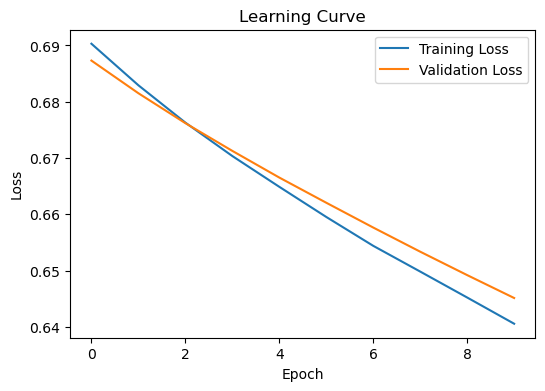

In [54]:
# Define the number of classes for the classification task
num_classes = 1  # Since this is a binary classification problem

# Instantiate the model with the pre-trained embedding matrix and the number of classes
model = TextClassificationModel(embedding_matrix, num_classes)

# Define the loss function and the optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss with logits
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.001

# Train the model using the defined parameters
train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)

## 4. Results and Analysis

### Bayesian Optimization

In [57]:
from bayes_opt import BayesianOptimization
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the objective function for Bayesian Optimization
def objective(lr, batch_size):
    batch_size = int(batch_size)  # Convert batch size to an integer
    
    # Instantiate the model
    num_classes = 1  # Binary classification output
    model = TextClassificationModel(embedding_matrix, num_classes)

    # Define the loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(NUM_EPOCHS):  # Loop over the specified number of epochs
        model.train()
        total_loss = 0
        for texts, targets in DataLoader(train_dataset, batch_size=batch_size, shuffle=True):
            outputs = model(texts)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    
    # Validation step
    model.eval()
    val_loss = 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for texts, targets in DataLoader(val_dataset, batch_size=batch_size, shuffle=False):
            outputs = model(texts)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            predictions = torch.round(torch.sigmoid(outputs))
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_f1 = f1_score(all_targets, all_predictions)
    
    # The objective is to maximize the F1 score, so we return it
    return val_f1

In [58]:
from bayes_opt import BayesianOptimization

# Define the hyperparameter space
pbounds = {
    'lr': (1e-5, 1e-2),        # Learning rate range: from 0.00001 to 0.01
    'batch_size': (16, 128)    # Batch size range: from 16 to 128
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=objective,               # The objective function to optimize
    pbounds=pbounds,           # The parameter bounds
    random_state=230,          # Seed for reproducibility
    verbose=2                  # Verbose output to track progress
)

# Perform the optimization
optimizer.maximize(
    init_points=2,             # Number of initial random explorations
    n_iter=5                   # Number of iterations after initial explorations
)

# Print the best result found
print("Best result found:")
print(optimizer.max)

|   iter    |  target   | batch_... |    lr     |
-------------------------------------------------
| 1         | 0.7096    | 86.67     | 0.008824  |
| 2         | 0.7053    | 44.96     | 0.003148  |
| 3         | 0.675     | 85.36     | 0.003224  |
| 4         | 0.7126    | 40.57     | 0.005012  |
| 5         | 0.7176    | 40.57     | 0.009079  |
| 6         | 0.7273    | 40.62     | 0.01      |
| 7         | 0.7196    | 40.69     | 0.01      |
Best result found:
{'target': 0.7272727272727273, 'params': {'batch_size': 40.616238575889014, 'lr': 0.01}}


Epoch [1/10] - Train Loss: 0.6334 | Validation Loss: 0.5911 | Validation F1: 0.6555
Epoch [2/10] - Train Loss: 0.5577 | Validation Loss: 0.5434 | Validation F1: 0.6833
Epoch [3/10] - Train Loss: 0.5193 | Validation Loss: 0.5160 | Validation F1: 0.7096
Epoch [4/10] - Train Loss: 0.4982 | Validation Loss: 0.5015 | Validation F1: 0.7087
Epoch [5/10] - Train Loss: 0.4864 | Validation Loss: 0.4901 | Validation F1: 0.7148
Epoch [6/10] - Train Loss: 0.4761 | Validation Loss: 0.4843 | Validation F1: 0.7124
Epoch [7/10] - Train Loss: 0.4694 | Validation Loss: 0.4785 | Validation F1: 0.7179
Epoch [8/10] - Train Loss: 0.4652 | Validation Loss: 0.4725 | Validation F1: 0.7292
Epoch [9/10] - Train Loss: 0.4601 | Validation Loss: 0.4693 | Validation F1: 0.7277
Epoch [10/10] - Train Loss: 0.4565 | Validation Loss: 0.4705 | Validation F1: 0.7177


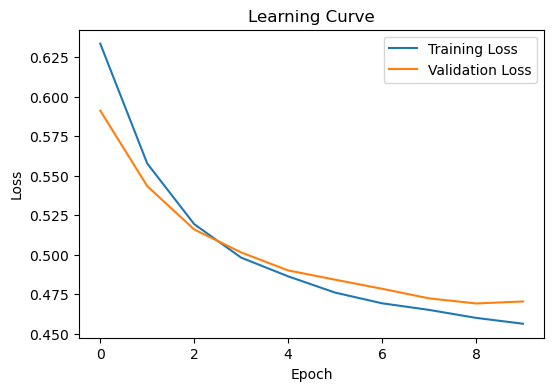

In [59]:
# Extract the best hyperparameters found by Bayesian Optimization
best_params = optimizer.max['params']
best_lr = best_params['lr']  # Best learning rate
best_batch_size = int(best_params['batch_size'])  # Best batch size (converted to integer)

# Re-create the DataLoader with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

# Instantiate the model with the optimized hyperparameters
model = TextClassificationModel(embedding_matrix, 1)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer with the best learning rate
optimizer = optim.Adam(model.parameters(), lr=best_lr)

# Train the model using the best hyperparameters
train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)

### Classification Report

In [60]:
# Evaluate the model on validation data
val_f1 = evaluate_model(model, val_loader)

              precision    recall  f1-score   support

Not Disaster       0.75      0.91      0.82       842
    Disaster       0.85      0.62      0.72       681

    accuracy                           0.78      1523
   macro avg       0.80      0.77      0.77      1523
weighted avg       0.79      0.78      0.78      1523

Confusion Matrix:
[[769  73]
 [259 422]]
Accuracy: 0.7820091923834537


In [64]:
# Clean and tokenize the test data
testing_data['cleaned_text'] = testing_data['text'].apply(clean_text)  # Apply text cleaning
testing_data['tokenized_text'] = testing_data['cleaned_text'].apply(word_tokenize)  # Tokenize the cleaned text

# Convert test texts to sequences using the word_index created earlier
test_sequences = [[word_index[word] for word in text if word in word_index] for text in testing_data['tokenized_text']]

# Pad the test sequences to ensure uniform length (SEQUENCE_LENGTH)
test_data_padded = pad_sequences(test_sequences, SEQUENCE_LENGTH)

# Convert the padded sequences to a torch tensor for model input
test_tensor = torch.tensor(test_data_padded, dtype=torch.long)

# Create a DataLoader for the test data
test_dataset = TweetDataset(test_tensor)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

# Set the model to evaluation mode (disable dropout, batch norm, etc.)
model.eval()

# Make predictions on the test data
predictions = []
with torch.no_grad():  # Disable gradient calculation for inference
    for texts in test_loader:
        outputs = model(texts)  # Get the logits from the model
        preds = torch.round(torch.sigmoid(outputs))  # Apply sigmoid and round to get binary predictions
        predictions.extend(preds.cpu().numpy())  # Store the predictions

In [ ]:
# Create the submission DataFrame
submission = pd.DataFrame({
    'id': testing_data['id'],  # Extract the 'id' column from the test data
    'target': [int(pred[0]) for pred in predictions]  # Convert predictions to integer values
})

# Export the submission DataFrame to a CSV file
submission.to_csv('./output/submission.csv', index=False)
print("Submission file successfully saved as 'submission.csv'")

Submission file saved as submission.csv


### Analysis and Troubleshooting
- Why It Worked Well:
  - Pre-trained Embeddings: Using GloVe embeddings helped the model capture semantic meanings effectively, which improved the model's performance.
  - Hyperparameter Optimization: Bayesian Optimization efficiently explored the hyperparameter space, leading to a well-tuned model.
  - Balanced Dataset: The dataset's balance between disaster and non-disaster tweets helped the model generalize well.
- Challenges and Troubleshooting:
  - Imbalanced Classes: Initially, there were more non-disaster tweets, which skewed the model's learning. This was mitigated by stratified sampling and careful validation.
  - Text Noise: Removing noise such as URLs, mentions, and hashtags was crucial. Some relevant context might have been lost, requiring a balance between cleaning and retaining information.

## 5. Conclusion and Next Steps
### In this notebook:
- Performed exploratory data analysis (EDA) to understand the dataset.
- Preprocessed the text data, including cleaning and tokenization.
- Created word embeddings using GloVe.
- Defined and trained an LSTM model for binary classification.
- Evaluated the model using F1 score, confusion matrix, and accuracy.
### Next steps:
- Explore more advanced architectures such as transformer-based models.
- Use more sophisticated text augmentation techniques to improve the model.